In [1]:
import pickle  
import mygene
from gseapy import read_gmt
import anndata as ad
import numpy as np
import pandas as pd
import os
mg = mygene.MyGeneInfo()


In [2]:
def load_cache(cache_file):
    """Load data from a cache file if it exists."""
    if os.path.exists(cache_file):
        print(f"Loading cached data from {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    return None

In [3]:
cache_file = "/labs/Aguiar/SSPA_BRAY/BRay/ajm_dataset_cache.h5ad"

In [4]:
adata = ad.read_h5ad(cache_file)

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
ajm_cyto_samples = adata[adata.obs['dataset'] == 'cyto']

In [6]:
ajm_cyto_samples

View of AnnData object with n_obs × n_vars = 2666 × 57010
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'dataset'
    var: 'gene_symbols'

In [7]:
ajm_cyto_samples.obs['cyto']

34_01_27__s1_WT100    0
34_01_53__s1_WT100    0
34_01_60__s1_WT100    0
34_02_20__s1_WT100    0
34_03_35__s1_WT100    0
                     ..
39_86_93__s8_WT100    0
39_87_48__s8_WT100    0
39_87_60__s8_WT100    0
39_89_66__s8_WT100    0
39_92_24__s8_WT100    0
Name: cyto, Length: 2666, dtype: category
Categories (2, object): ['0', '1']

In [8]:
gene_annotation_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_FileTransfer/ENS_mouse_geneannotation.csv"
gene_annotation = pd.read_csv(gene_annotation_path)
gene_annotation = gene_annotation.set_index('GeneID')

In [9]:
def filter_protein_coding_genes(adata, gene_annotation):
    protein_coding_genes = gene_annotation[gene_annotation['Genetype'] == 'protein_coding'].index
    
    common_genes = np.intersect1d(adata.var_names, protein_coding_genes)
    
    print(f"Total genes: {adata.n_vars}")
    print(f"Protein-coding genes found: {len(common_genes)}")
    
    adata_filtered = adata[:, common_genes].copy()
    
    return adata_filtered

In [10]:
ajm_cyto_filtered = filter_protein_coding_genes(ajm_cyto_samples, gene_annotation)

Total genes: 57010
Protein-coding genes found: 21501


In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

In [12]:
# Get the list of Ensembl IDs from the anndata object's var_names
ensembl_ids = ajm_cyto_filtered.var_names.tolist()

# Query MyGene.info to get the corresponding gene symbols
# We'll reuse the gene_info_df if it's for the same set of genes, or requery if necessary.
# Assuming the genes in ajm_cyto_samples are the same as in ajm_filtered
gene_info_df = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse', as_dataframe=True)

# Create a dictionary to map Ensembl IDs to gene symbols
gene_map = gene_info_df['symbol'].dropna().to_dict()

# Create a new list of gene names, using the symbol if available, otherwise keeping the Ensembl ID
new_var_names = [gene_map.get(eid, eid) for eid in ajm_cyto_filtered.var_names]

# Assign the new names to the anndata object
ajm_cyto_filtered.var_names = new_var_names

# AnnData requires unique variable names, so we make them unique.
# This will append '-1', '-2', etc. to duplicate names.
ajm_cyto_filtered.var_names_make_unique()

# Display the anndata object to verify the change
print(ajm_cyto_filtered)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSMUSG00000072694', 2)]
94 input query terms found no hit:	['ENSMUSG00000022591', 'ENSMUSG00000034007', 'ENSMUSG00000040715', 'ENSMUSG00000040838', 'ENSMUSG000


AnnData object with n_obs × n_vars = 2666 × 21501
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'dataset'
    var: 'gene_symbols'


In [13]:
# First, let's check the shape of your data
print(f"Data shape: {ajm_cyto_filtered.X.shape}")

# For proper per-cell totals, we need to flatten the result:
cell_totals = np.array(ajm_cyto_filtered.X.sum(axis=1)).flatten()
print(f"Median total counts per cell: {np.median(cell_totals)}")
print(f"Mean total counts per cell: {np.mean(cell_totals)}")

Data shape: (2666, 21501)
Median total counts per cell: 2812.0
Mean total counts per cell: 6422.919354838709


In [14]:
# Normalize each cell to a total count of 10,000
sc.pp.normalize_total(ajm_cyto_filtered, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(ajm_cyto_filtered)

In [15]:
# Check the distribution of values in the 'cyto' column
print("Cell counts per 'cyto' group:")
print(ajm_cyto_filtered.obs['cyto'].value_counts())

# The 'cyto' column is likely numeric (0 and 1). For clarity and best practice with Scanpy, 
# it's good to convert it to a categorical type. This also helps in plotting.
ajm_cyto_filtered.obs['cyto'] = ajm_cyto_filtered.obs['cyto'].astype('category')

print("\nData type of 'cyto' column after conversion:")
print(ajm_cyto_filtered.obs['cyto'].dtype)

Cell counts per 'cyto' group:
cyto
0    2060
1     606
Name: count, dtype: int64

Data type of 'cyto' column after conversion:
category


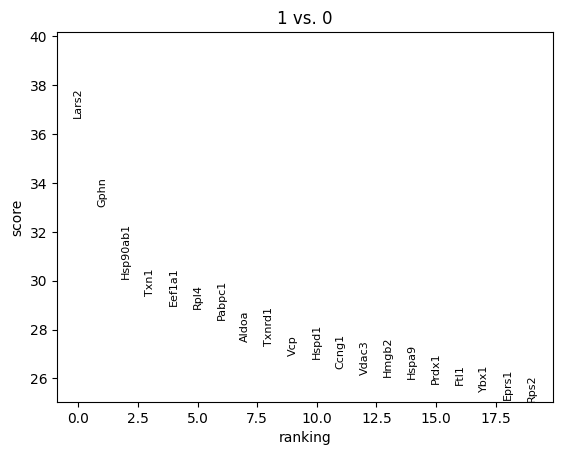

In [16]:
# --- Running the DGE Test: 'cyto=1' vs 'cyto=0' ---

# Group by the 'cyto' column
# Use 'wilcoxon' as it's a robust default test
# Set reference='0' to make group '0' the baseline for comparison
sc.tl.rank_genes_groups(
    ajm_cyto_filtered, 
    groupby='cyto', 
    method='wilcoxon', 
    reference='0',  # This is the crucial part for a direct 1 vs 0 comparison
    use_raw=False   # Use the log-normalized data we prepared
)

# Plot a summary of the top genes that differ between the groups
sc.pl.rank_genes_groups(ajm_cyto_filtered, n_genes=20, sharey=False, show=True)

In [17]:
# --- Extracting and Filtering the DGE Results ---

# The comparison is '1' vs '0', so we extract the results for group '1'
cyto1_vs_0_results_df = sc.get.rank_genes_groups_df(ajm_cyto_filtered, group='1')

# Define our significance thresholds
fdr_threshold = 0.05  # Adjusted p-value < 0.05
lfc_threshold = 1.0   # Log2 Fold Change > 1 (meaning at least 2-fold change)

# Filter for SIGNIFICANTLY UPREGULATED genes in the 'cyto=1' group
upregulated_genes = cyto1_vs_0_results_df[
    (cyto1_vs_0_results_df['pvals_adj'] < fdr_threshold) & 
    (cyto1_vs_0_results_df['logfoldchanges'] > lfc_threshold)
]

# Filter for SIGNIFICANTLY DOWNREGULATED genes in the 'cyto=1' group
downregulated_genes = cyto1_vs_0_results_df[
    (cyto1_vs_0_results_df['pvals_adj'] < fdr_threshold) & 
    (cyto1_vs_0_results_df['logfoldchanges'] < -lfc_threshold)
]

print(f"Found {len(upregulated_genes)} significantly UPREGULATED genes in 'cyto=1' vs 'cyto=0'.")
print("Top 10 upregulated genes:")
print(upregulated_genes.head(10))

print("-" * 50)

print(f"\nFound {len(downregulated_genes)} significantly DOWNREGULATED genes in 'cyto=1' vs 'cyto=0'.")
print("Top 10 downregulated genes:")
print(downregulated_genes.head(10))

# Save the full list to a CSV file for your records
upregulated_genes.to_csv("cyto1_vs_0_upregulated_genes.csv")
downregulated_genes.to_csv("cyto1_vs_0_downregulated_genes.csv")

Found 5573 significantly UPREGULATED genes in 'cyto=1' vs 'cyto=0'.
Top 10 upregulated genes:
      names     scores  logfoldchanges          pvals      pvals_adj
0     Lars2  36.682381        2.841695  1.394686e-294  2.998714e-290
1      Gphn  33.044220        1.853663  1.883324e-239  2.024668e-235
2  Hsp90ab1  30.090015        2.255264  6.545710e-199  4.691311e-195
3      Txn1  29.398827        4.255512  5.684759e-190  3.055700e-186
4    Eef1a1  28.981937        2.105954  1.111414e-184  3.982752e-181
5      Rpl4  28.860126        2.163410  3.781755e-183  1.161593e-179
6    Pabpc1  28.388126        2.116167  2.834094e-177  7.616981e-174
7     Aldoa  27.479847        3.349070  3.057454e-166  7.304258e-163
8    Txnrd1  27.331738        3.257971  1.780364e-164  3.827961e-161
9       Vcp  26.923857        2.831574  1.154691e-159  2.257001e-156
--------------------------------------------------

Found 79 significantly DOWNREGULATED genes in 'cyto=1' vs 'cyto=0'.
Top 10 downregulated genes:

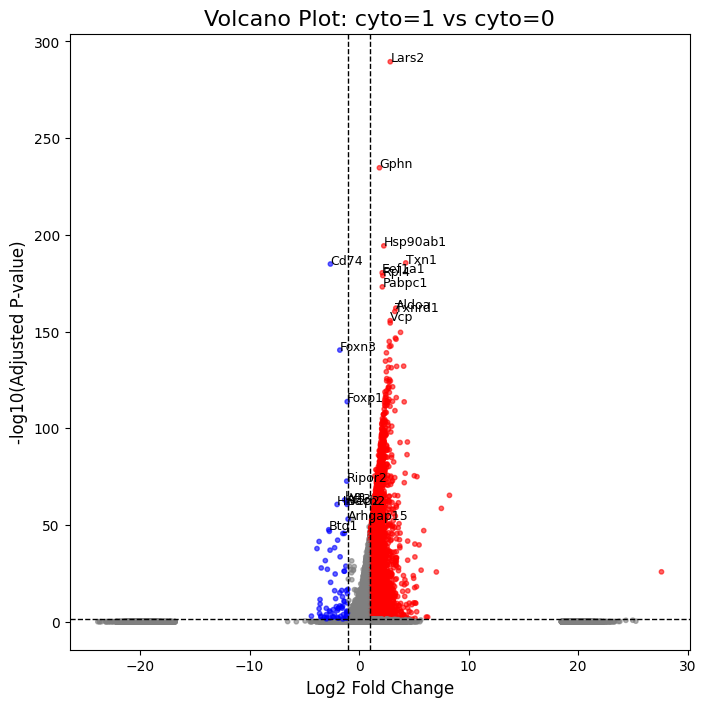

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume you have your results in this dataframe from the previous step
# cyto1_vs_0_results_df = sc.get.rank_genes_groups_df(ajm_cyto_filtered, group='1')

# --- Manual Volcano Plot ---

# 1. Prepare the data for plotting
# We need log2foldchanges on the x-axis and -log10(adjusted p-value) on the y-axis
df_for_plot = cyto1_vs_0_results_df.copy()

# Calculate the -log10 p-value. We add a tiny number to avoid log(0) errors.
df_for_plot['-log10_pvals_adj'] = -np.log10(df_for_plot['pvals_adj'] + 1e-300)

# 2. Define colors for significant/non-significant genes
# We'll use the same thresholds as before
fdr_threshold = 0.05
lfc_threshold = 1.0

# Create a new column to hold color labels
df_for_plot['color'] = 'grey' # Default to grey
df_for_plot.loc[(df_for_plot['pvals_adj'] < fdr_threshold) & (df_for_plot['logfoldchanges'] > lfc_threshold), 'color'] = 'red'
df_for_plot.loc[(df_for_plot['pvals_adj'] < fdr_threshold) & (df_for_plot['logfoldchanges'] < -lfc_threshold), 'color'] = 'blue'

# 3. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(
    x=df_for_plot['logfoldchanges'],
    y=df_for_plot['-log10_pvals_adj'],
    c=df_for_plot['color'],
    s=10, # size of points
    alpha=0.6 # transparency
)

# 4. Add threshold lines
plt.axhline(y=-np.log10(fdr_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)

# 5. Add labels and title
plt.title("Volcano Plot: cyto=1 vs cyto=0", fontsize=16)
plt.xlabel("Log2 Fold Change", fontsize=12)
plt.ylabel("-log10(Adjusted P-value)", fontsize=12)
plt.grid(False) # Turn off the background grid

# Optional: Add labels for the top genes to make the plot more informative
# Get top 10 upregulated and top 10 downregulated genes
top_up = df_for_plot[df_for_plot['color']=='red'].nlargest(10, '-log10_pvals_adj')
top_down = df_for_plot[df_for_plot['color']=='blue'].nlargest(10, '-log10_pvals_adj')
top_genes = pd.concat([top_up, top_down])

for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], row['-log10_pvals_adj'], row['names'], fontsize=9)

plt.show()

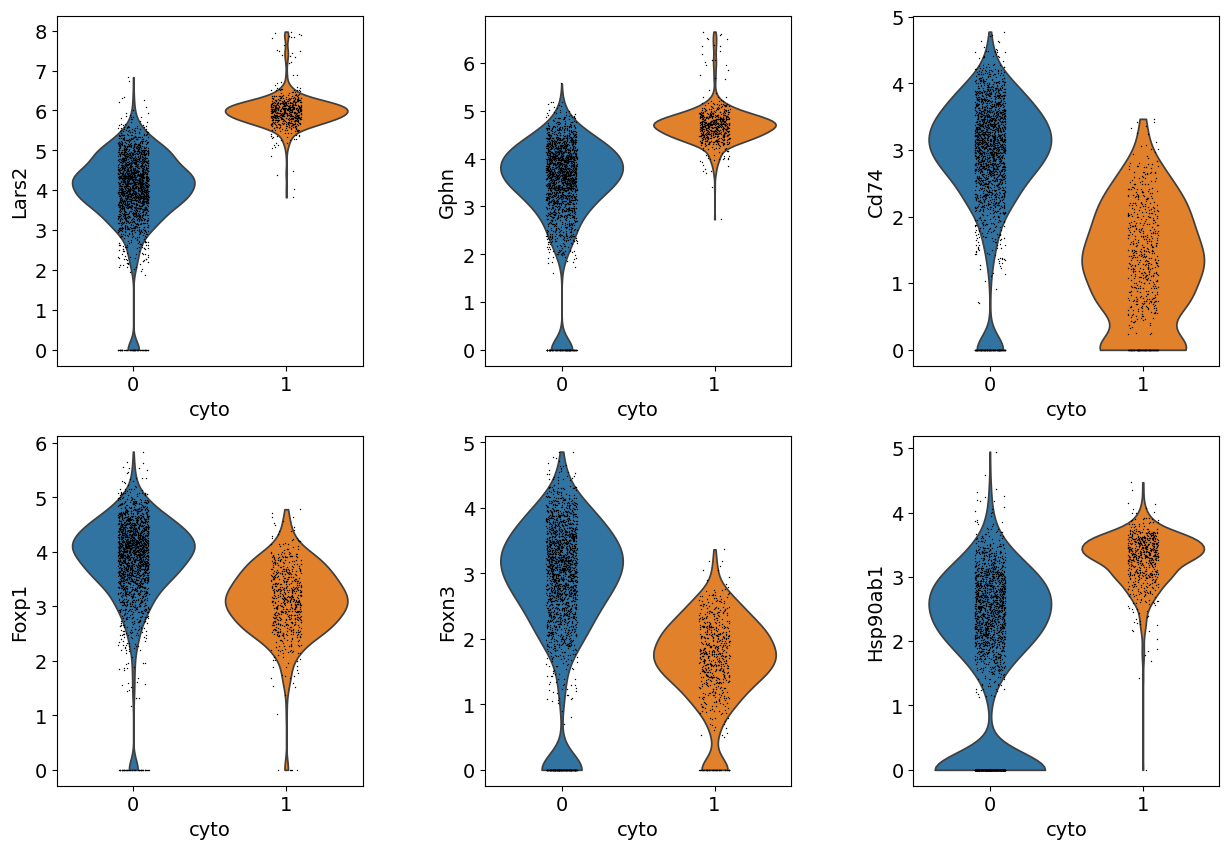

In [19]:
# After running DGE, you can do this:
top_genes_to_plot = ['Lars2', 'Gphn', 'Cd74', 'Foxp1', 'Foxn3', 'Hsp90ab1']

# Use a context manager to temporarily set a larger font size for the plot
with plt.rc_context({'font.size': 14}):
    # Create a figure with a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Flatten the 2D array of axes for easy iteration
    axes_flat = axes.flatten()

    # Loop through each gene and its corresponding axis to create a violin plot
    for i, gene in enumerate(top_genes_to_plot):
        sc.pl.violin(
            ajm_cyto_filtered, 
            keys=gene, 
            groupby='cyto', 
            ax=axes_flat[i], 
            show=False  # Do not show the plot immediately
        )

    # Adjust the horizontal space between subplots
    plt.subplots_adjust(wspace=0.4)
    
    # Display the entire figure
    plt.show()


In [20]:
# You already have the DGE results stored in the anndata object.
# Let's extract the full results for the 'cyto=1' vs 'cyto=0' comparison.
gsea_input_df = sc.get.rank_genes_groups_df(ajm_cyto_filtered, group='1')

# Now, create the specific format gseapy needs:
# A pandas Series with gene names as the index and the ranking metric as the values.
# The 'scores' column is a great choice for the ranking metric.
ranked_gene_list = gsea_input_df.set_index('names')['scores']

# It's good practice to sort the list to see what it looks like.
# High positive scores = upregulated in cyto=1. High negative scores = downregulated in cyto=1.
ranked_gene_list = ranked_gene_list.sort_values(ascending=False)

# Clean up by removing any potential duplicate gene names or NaNs
ranked_gene_list = ranked_gene_list[~ranked_gene_list.index.duplicated(keep='first')]
ranked_gene_list.dropna(inplace=True)


print("Top of our ranked gene list (most upregulated in cyto=1):")
print(ranked_gene_list.head())
print("\nBottom of our ranked gene list (most downregulated in cyto=1):")
print(ranked_gene_list.tail())

Top of our ranked gene list (most upregulated in cyto=1):
names
Lars2       36.682381
Gphn        33.044220
Hsp90ab1    30.090015
Txn1        29.398827
Eef1a1      28.981937
Name: scores, dtype: float32

Bottom of our ranked gene list (most downregulated in cyto=1):
names
Lyn      -17.065792
Ripor2   -18.354427
Foxp1    -23.010763
Foxn3    -25.570713
Cd74     -29.346264
Name: scores, dtype: float32


In [21]:
import gseapy

# --- Running GSEA Prerank ---

print("Running GSEA on Hallmark gene sets. This may take a minute...")

# The organism is 'Mouse' since that's your data source
gs_res = gseapy.prerank(
    rnk=ranked_gene_list,
    gene_sets='MSigDB_Hallmark_2020',
    organism='Mouse',
    seed=42  # for reproducibility
)

# The results are a dictionary-like object. The main results table is in `.res2d`
gsea_results_df = gs_res.res2d

# Let's view the top results sorted by significance (fdr)
print("\n--- GSEA Results ---")
print(gsea_results_df.sort_values('FDR q-val').head(15))

2025-06-23 14:51:53,473 [WARNING] Duplicated values found in preranked stats: 42.53% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Running GSEA on Hallmark gene sets. This may take a minute...

--- GSEA Results ---
       Name                             Term        ES       NES NOM p-val  \
0   prerank                   Myc Targets V1  0.803089  1.419891       0.0   
1   prerank        Unfolded Protein Response  0.706999  1.237659       0.0   
2   prerank                   Myc Targets V2  0.712473  1.219737       0.0   
3   prerank        Oxidative Phosphorylation   0.68262  1.206021       0.0   
4   prerank                      E2F Targets  0.672609  1.188369       0.0   
5   prerank                 mTORC1 Signaling  0.659694  1.165543       0.0   
6   prerank                Protein Secretion  0.663214  1.153822       0.0   
8   prerank                  G2-M Checkpoint  0.649084  1.146103       0.0   
7   prerank                       DNA Repair  0.652562  1.147019       0.0   
10  prerank         PI3K/AKT/mTOR  Signaling  0.637127  1.112677     0.007   
9   prerank  Reactive Oxygen Species Pathway  0.653918  1.

In [22]:
print(gsea_results_df.columns)

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')


In [23]:
gseapy.barplot(
    gs_res.res2d,
    column='FDR q-val',
    title='Hallmark Pathways in cyto=1 vs cyto=0',
    ofname='gsea_hallmark_barplot.png'
)


Plotting the enrichment for the top pathway: Myc Targets V1


[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

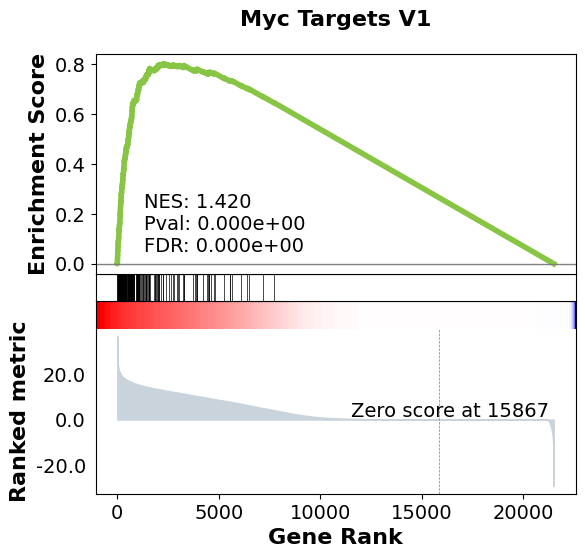

In [24]:
# Get the name of the top enriched pathway from your results.
# The results are sorted, so the top pathway is in the first row.
# The pathway name is in the 'Term' column.
top_pathway_name = gsea_results_df['Term'].iloc[0]

print(f"\nPlotting the enrichment for the top pathway: {top_pathway_name}")

# Generate the plot using the correct pathway name as the key
gseapy.gseaplot(
    rank_metric=gs_res.ranking, 
    term=top_pathway_name, 
    **gs_res.results[top_pathway_name]
)

In [25]:
cytobeam_csv_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_AJM2/2_Data/1_ASGs/CYTOBEAM_genes.csv"

CYTOBEAM_df = pd.read_csv(cytobeam_csv_path)

CYTOBEAM = CYTOBEAM_df.iloc[:, 0].tolist()

print(f"Number of genes in CYTOBEAM: {len(CYTOBEAM)}")

Number of genes in CYTOBEAM: 420


In [26]:
# --- Analysis of CYTOBEAM Gene Set Overlap with DGE Results ---

# Convert the CYTOBEAM gene list to a set for efficient lookups
cytobeam_set = set(CYTOBEAM)

# 1. Find which CYTOBEAM genes are in the list of significantly UPREGULATED genes
upregulated_cytobeam_genes = upregulated_genes[upregulated_genes['names'].isin(cytobeam_set)]

# 2. Find which CYTOBEAM genes are in the list of significantly DOWNREGULATED genes
downregulated_cytobeam_genes = downregulated_genes[downregulated_genes['names'].isin(cytobeam_set)]

# 3. Get the DGE statistics for ALL CYTOBEAM genes that were detected in the experiment
all_cytobeam_dge_stats = cyto1_vs_0_results_df[cyto1_vs_0_results_df['names'].isin(cytobeam_set)].copy()
# Sort by log fold change to see the most up- and down-regulated genes at the top and bottom
all_cytobeam_dge_stats.sort_values('logfoldchanges', ascending=False, inplace=True)


# --- Print the Summary ---

print(f"Total genes in CYTOBEAM signature: {len(CYTOBEAM)}")
print(f"Total CYTOBEAM genes detected in the experiment: {len(all_cytobeam_dge_stats)}")
print("-" * 60)

print(f"\nFound {len(upregulated_cytobeam_genes)} CYTOBEAM genes among the significantly UPREGULATED genes:")
# Display the details for these genes
with pd.option_context('display.max_rows', 10):
    print(upregulated_cytobeam_genes[['names', 'logfoldchanges', 'pvals_adj']])

print("\n" + "-" * 60)

print(f"\nFound {len(downregulated_cytobeam_genes)} CYTOBEAM genes among the significantly DOWNREGULATED genes:")
# Display the details for these genes
with pd.option_context('display.max_rows', 10):
    print(downregulated_cytobeam_genes[['names', 'logfoldchanges', 'pvals_adj']])

print("\n" + "-" * 60)

print("\nFull DGE statistics for all detected CYTOBEAM genes (sorted by Log2 Fold Change):")
# Display the full list to see the overall trend
with pd.option_context('display.max_rows', len(all_cytobeam_dge_stats)):
    print(all_cytobeam_dge_stats[['names', 'logfoldchanges', 'pvals_adj']])

Total genes in CYTOBEAM signature: 420
Total CYTOBEAM genes detected in the experiment: 417
------------------------------------------------------------

Found 171 CYTOBEAM genes among the significantly UPREGULATED genes:
        names  logfoldchanges      pvals_adj
12      Vdac3        3.309842  2.178019e-147
13      Hmgb2        3.370963  8.918015e-147
23       Ezh2        2.937785  5.011438e-132
44      Gapdh        3.050448  1.149696e-114
60       Tcp1        2.241921  6.757467e-108
...       ...             ...            ...
8380    Ccl22        2.452990   6.622702e-03
8538    Cebpb        1.591230   1.603126e-02
8619    Rbbp9        1.701715   2.283682e-02
8629   Cxcl10        2.792798   2.359478e-02
8729  Dynlt1c        1.530484   3.619177e-02

[171 rows x 3 columns]

------------------------------------------------------------

Found 10 CYTOBEAM genes among the significantly DOWNREGULATED genes:
         names  logfoldchanges      pvals_adj
21340     Cd55       -1.489470   3.6

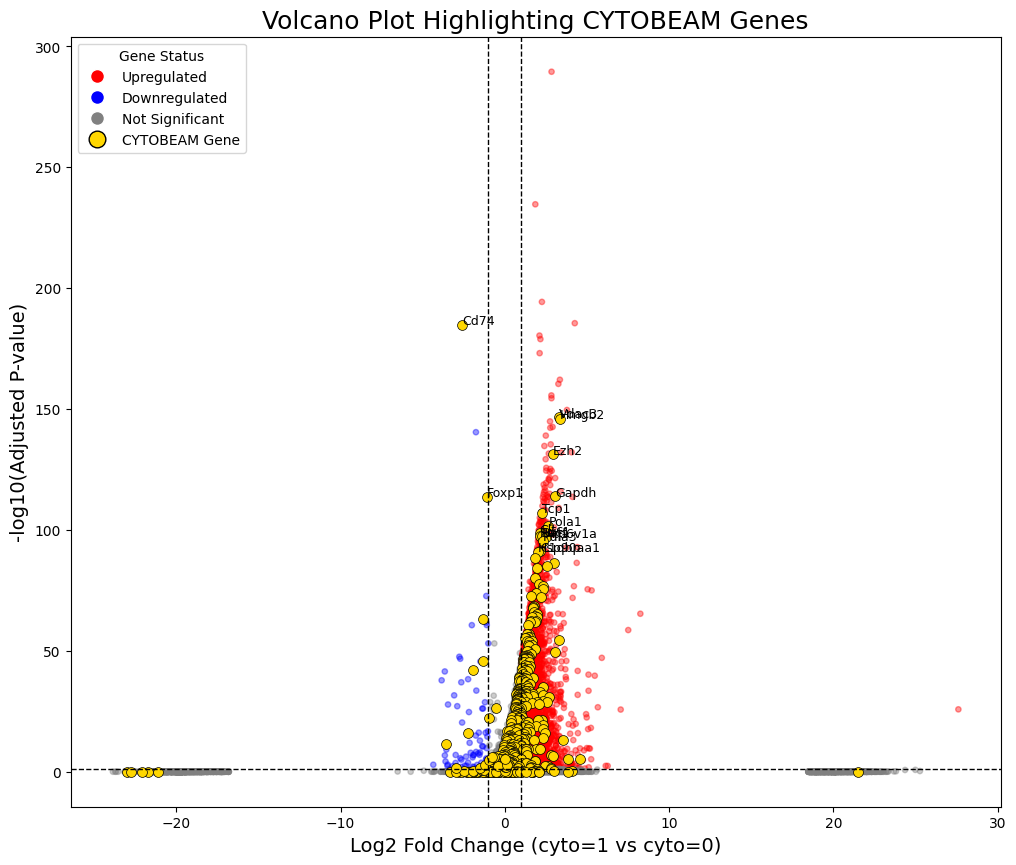

In [27]:
from matplotlib.lines import Line2D

# --- Enhanced Volcano Plot with CYTOBEAM Highlighting ---

# 1. Get the list of CYTOBEAM gene names that are present in our DGE results
cytobeam_genes_in_data = set(all_cytobeam_dge_stats['names'])

# 2. Create the base plot
plt.figure(figsize=(12, 10))

# Plot all genes with the standard red/blue/grey coloring from the 'color' column
plt.scatter(
    x=df_for_plot['logfoldchanges'],
    y=df_for_plot['-log10_pvals_adj'],
    c=df_for_plot['color'],
    s=15, # point size
    alpha=0.4 # transparency
)

# 3. Overlay the CYTOBEAM genes to highlight them
# Filter the main dataframe to get the coordinates for CYTOBEAM genes
cytobeam_plot_data = df_for_plot[df_for_plot['names'].isin(cytobeam_genes_in_data)]

plt.scatter(
    x=cytobeam_plot_data['logfoldchanges'],
    y=cytobeam_plot_data['-log10_pvals_adj'],
    c='gold',
    s=50, # make them larger
    alpha=1.0,
    edgecolors='black', # add a border to make them stand out
    linewidth=0.5
)

# 4. Add threshold lines (same as before)
plt.axhline(y=-np.log10(fdr_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)

# 5. Add labels and title
plt.title("Volcano Plot Highlighting CYTOBEAM Genes", fontsize=18)
plt.xlabel("Log2 Fold Change (cyto=1 vs cyto=0)", fontsize=14)
plt.ylabel("-log10(Adjusted P-value)", fontsize=14)
plt.grid(False)

# 6. Annotate the most significant CYTOBEAM genes
# Get significant CYTOBEAM genes and sort by p-value to find the top ones
top_cytobeam_to_label = cytobeam_plot_data.nlargest(15, '-log10_pvals_adj')

for i, row in top_cytobeam_to_label.iterrows():
    plt.text(row['logfoldchanges'], row['-log10_pvals_adj'], row['names'], fontsize=9)

# 7. Create a custom legend to explain the colors
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Upregulated', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Downregulated', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Not Significant', markerfacecolor='grey', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='CYTOBEAM Gene', 
           markerfacecolor='gold', markeredgecolor='black', markersize=12)
]
plt.legend(handles=legend_elements, title='Gene Status', loc='upper left')

plt.show()